# Mathematics of XGBoost
This notebook shows the mathematics of leaf node weights and split gains by using an XGBoost model with 2 depth-1 trees.

## Fit XGBoost Model

Feature importance:
{'x1': 1.0, 'x2': 1.0}
Feature importance:
{'x1': 0.1666666865348816, 'x2': 0.21735870838165283}
Feature importance:
{'x1': 0.1666666865348816, 'x2': 0.21735870838165283}
Feature importance:
{'x1': 1.0, 'x2': 0.9863643050193787}
Feature importance:
{'x1': 1.0, 'x2': 0.9863643050193787}
Tree rules:
booster[0]:
0:[x1<6] yes=1,no=2,missing=2,gain=0.166666687,cover=1
	1:leaf=-0.333333343,cover=0.5
	2:leaf=-0,cover=0.5
booster[1]:
0:[x2<7] yes=1,no=2,missing=2,gain=0.217358708,cover=0.986364305
	1:leaf=0.0276490804,cover=0.493182153
	2:leaf=-0.307206243,cover=0.493182153

0:[x1<6] yes=1,no=2,missing=2
	1:leaf=-0.333333343
	2:leaf=-0

0:[x2<7] yes=1,no=2,missing=2
	1:leaf=0.0276490804
	2:leaf=-0.307206243



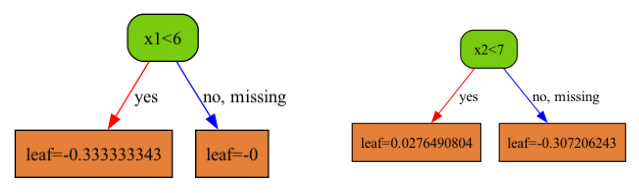

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as  plt

reg_lambda = 1
learning_rate = 0.5
n_estimators = 2
param = {"n_estimators": n_estimators,
         'lambda':reg_lambda,
         'base_score':0.5,
         'max_depth':1, 
         'eta':learning_rate, 
         'objective':'binary:logistic'}
model = xgb.XGBClassifier(min_child_weight=0,**param)
train=pd.DataFrame({'x1':[4,8,6,4],
                    'x2':[8,7,6,5],
                    'y':[0,0,1,0]})
model.fit(train[['x1','x2']], train['y'])

booster=model.get_booster()
#Feature importance
for type in ['weight','gain','total_gain','cover','total_cover']:
    print(f"Feature importance:\n{booster.get_score(importance_type=type)}")

# Tree rules
booster.dump_model('xgb_model.txt', with_stats = True)
with open('xgb_model.txt', 'r') as f:
   print(f"Tree rules:\n{f.read()}")

trees=booster.get_dump()
for tree in trees:
    print(tree)

node_params = {'shape': 'box',
               'style': 'filled, rounded',
               'fillcolor': '#78cbe'} 
leaf_params = {'shape': 'box',
               'style': 'filled',
               'fillcolor': '#e48038'}

fix,axs=plt.subplots(1,n_estimators,figsize=(8,4))
for i in range(n_estimators):
    xgb.plot_tree(model, num_trees=i, ax = axs[i],
                  condition_node_params=node_params,
                  leaf_node_params=leaf_params)

## Mathematics of Booster
### Booster Leaf Value

For $i$th booster in the $n$ boosters, denote its mapping of record $\mathbf{x}$ to the index of one of the $K$ leaf node as $f_i : \mathbf{x} \;\mapsto\; \{1,2,\dots,K\}$.

For a record $\mathbf{x}, y$, denote its probability after $i$th booster as $p^{(i)}$. With the regularization term $\lambda$, the score of the $k$th leaf node of $i$th booster 

$$
w_{i,k} = \frac{\sum_{\mathbf{x}\in\cal{X}, f_i(\mathbf{x})=k}\left[y-p^{(i-1)}\right]}{\lambda+\sum_{\mathbf{x}\in\cal{X},f_i(\mathbf{x})=k}p^{(i-1)}\left[1-p^{(i-1)}\right]}, p^{(0)}=0.5.
$$

The probability after $i$th booster is

$$
p^{(i)}=\text{expit}\left[\text{logit}(p^{(i-1)})+w_{i,f_i(\mathbf x)}\right].
$$

The calculation of $w_{i,k}$ is implemented in python as
```python
        (g[y] - g[p]).sum() / (reg_lambda + (g[p] * (1 - g[p])).sum())
```


### Booster Leaf Value

In [2]:
import re
from scipy.special import expit

def gen_booster(df,p,y,reg_lambda,group):
    cal_w = lambda g: (
        (g[y] - g[p]).sum() /
        (reg_lambda + (g[p] * (1 - g[p])).sum())
    )
    boost = df.groupby(group).apply(cal_w,include_groups=False)
    return boost.to_dict()

train['w0']=0 #base_score=0.5
for i,tree in enumerate(trees):
    train['p']=train['w0'].apply(expit) 
    print(f'\nAfter boost {i}\n{train}') 

    #group by tree rule
    rule=re.findall('\[(x[0-9]+<[0-9]*.*[0-9]+)\]', tree)[0]
    print(f'Tree rule: {rule}')
    train['grp']=train.apply(lambda x:eval('1 if x.'+rule+' else 2'),axis=1)
     
    #calculate leaf output
    boost=gen_booster(train,'p','y',reg_lambda,'grp')
    print(f'Leaf value of boost \n{boost}')

    #boost with leaf output
    train['w0']+=train['grp'].map(boost)*learning_rate
train['p'] = train['w0'].apply(expit) #update p with the lastest w.
print(train)

# Compare with xgboost output
proba = model.predict_proba(train[['x1','x2']])
print(f"\nXgboost output:\n{proba}")


After boost 0
   x1  x2  y  w0    p
0   4   8  0   0  0.5
1   8   7  0   0  0.5
2   6   6  1   0  0.5
3   4   5  0   0  0.5
Tree rule: x1<6
Leaf value of boost 
{1: -0.6666666666666666, 2: 0.0}

After boost 1
   x1  x2  y        w0        p  grp
0   4   8  0 -0.333333  0.41743    1
1   8   7  0  0.000000  0.50000    2
2   6   6  1  0.000000  0.50000    2
3   4   5  0 -0.333333  0.41743    1
Tree rule: x2<7
Leaf value of boost 
{1: 0.055298146882998354, 2: -0.6144125060537433}
   x1  x2  y        w0         p  grp
0   4   8  0 -0.640540  0.345125    2
1   8   7  0 -0.307206  0.423797    2
2   6   6  1  0.027649  0.506912    1
3   4   5  0 -0.305684  0.424169    1

Xgboost output:
[[0.6548754  0.3451246 ]
 [0.5762032  0.42379677]
 [0.4930882  0.5069118 ]
 [0.5758315  0.42416853]]


### Booster Split Gains
Ignoring the factor $1/2$ (being consistent with xgboost package), the gain of a split is
$$
\mathcal{L}
=\frac{\sum_{i\in L}(p_i-y_i)^2}{\sum_{i\in L}{p_i(1-p_i)}+\lambda}
+\frac{\sum_{i\in R}(p_i-y_i)^2}{\sum_{i\in R}{p_i(1-p_i)}+\lambda}
-\frac{\sum_{i}(p_i-y_i)^2}{\sum_{i}{p_i(1-p_i)}+\lambda}.
$$

In [3]:
import re
from scipy.special import expit

def gen_booster(df_in,p,y,reg_lambda,group):
    cal_w = lambda g: (
        (g[y] - g[p]).sum() /
        (reg_lambda + (g[p] * (1 - g[p])).sum())
    )
    boost = df_in.groupby(group).apply(cal_w,include_groups=False)
    # calculate gain
    df = df_in.copy()
    df['res']=df[y]-df[p]
    df['den']=df[p]*(1-df[p])
    agg = df.groupby(group)[['res', 'den']].sum()
    J_leaf = -(agg['res']**2) / (reg_lambda + agg['den'])
    J_root = -(agg['res'].sum()**2) / (reg_lambda + agg['den'].sum())
    gain = J_root - J_leaf.sum()
    return boost.to_dict(), float(gain)

gains = []
train['w0']=0 #base_score=0.5
for i,tree in enumerate(trees):
    train['p']=train['w0'].apply(expit) 
    #group by tree rule
    rule=re.findall('\[(x[0-9]+<[0-9]*.*[0-9]+)\]', tree)[0]
    train['grp']=train.apply(lambda x:eval('1 if x.'+rule+' else 2'),axis=1)
    #calculate leaf output
    boost, gain=gen_booster(train,'p','y',reg_lambda,'grp')
    gains.append(gain)
    #boost with leaf output
    train['w0']+=train['grp'].map(boost)*learning_rate

print(f"Manual calculated gain:\n{gains}")
print(f"Feature importance gain:\n{booster.get_score(importance_type='gain')}")

Manual calculated gain:
[0.16666666666666663, 0.2173587580259388]
Feature importance gain:
{'x1': 0.1666666865348816, 'x2': 0.21735870838165283}
